#Set up

In [1]:
%pip install opendatasets #{"username":"phuongleanh","key":"bfb9d4fb494830b2319c202c71c7977f"}
import opendatasets as od
od.download("https://www.kaggle.com/datasets/shubh0799/churn-modelling/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: phuongleanh
Your Kaggle Key: ··········


100%|██████████| 262k/262k [00:00<00:00, 566kB/s]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
df=pd.read_csv('/content/churn-modelling/Churn_Modelling.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
df.drop(columns=['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


#Split dataset

In [7]:
X = df.iloc[:,[col for col in range(11) if col !=10 ]]
y = df['Exited'].values

In [8]:
X= pd.get_dummies(df, columns=['Geography','Gender'])
X=X.values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

#Scale features

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) #scaler thì phải là 1D array (chuyển thành value)
X_test = scaler.transform(X_test)

#Plant a tree

##Calculate entropy

$$H(p_1) = -p_1 \text{log}_2(p_1) - (1- p_1) \text{log}_2(1- p_1)$$

In [11]:
def compute_entropy(y):
    """
    Computes the entropy for

    Args:
       y (ndarray): Numpy array indicating whether each example at a node is
           edible (`1`) or poisonous (`0`)

    Returns:
        entropy (float): Entropy at that node

    """
    entropy = 0.

    if len(y) != 0:
        p1 = 1 - sum(y)/len(y)
        if p1 == 0 or p1 == 1:
            entropy = 0.
        else:
            entropy = -p1*np.log2(p1)-(1-p1)*np.log2(1-p1)
    else:
        entropy = 0.

    return entropy

In [12]:
print("Entropy at root node: ", compute_entropy(y_train))

Entropy at root node:  0.7273941162814199


##Split nodes

In [13]:
def split_node(X, node_indices, feature):
    """
    Splits the data at the given node into
    left and right branches

    Args:
        X (ndarray):             Data matrix of shape(n_samples, n_features)
        node_indices (list):     List containing the active indices. I.e, the samples being considered at this step.
        feature (int):           Index of feature to split on

    Returns:
        left_indices (list):     Indices with feature value == 1
        right_indices (list):    Indices with feature value == 0
    """
    left_indices = []
    right_indices = []

    for i in range(len(X)):
        if i in node_indices:
            if X[i][feature] ==1:
                left_indices.append(i)
            else:
                right_indices.append(i)

    return left_indices, right_indices

##Calculate information gain

$$\text{Information Gain} = H(p_1^\text{node})- (w^{\text{left}}H(p_1^\text{left}) + w^{\text{right}}H(p_1^\text{right}))$$


In [14]:
def compute_information_gain(X, y, node_indices, feature):

    """
    Compute the information of splitting the node on a given feature

    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.

    Returns:
        cost (float):        Cost computed

    """
    # Split node
    left_indices, right_indices = split_node(X, node_indices, feature)

    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]

    information_gain = 0

    # Weights
    wl = len(left_indices) / len(node_indices)
    wr = len(right_indices) / len(node_indices)

    #Information gain
    information_gain = compute_entropy(y_node)-(wl*compute_entropy(y_left)+wr*compute_entropy(y_right))

    return information_gain

##Get best split

In [15]:
def get_best_split(X, y, node_indices):
    """
    Returns the optimal feature and threshold value
    to split the node data

    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.

    Returns:
        best_feature (int):     The index of the best feature to split
    """

    num_features = X.shape[1]
    best_feature = -1

    in_gain = []
    if sum(y) != 0 and sum(y) != len(y):
        for i in range(len(X[0])):
            in_gain.append(compute_information_gain(X, y, node_indices, i))
        best_feature = in_gain.index(max(in_gain))
    else:
        best_feature = -1

    return best_feature

## Finalize

In [16]:
tree = []

def build_tree_recursive(X, y, node_indices, branch_name, max_depth, current_depth):
    """
    Build a tree using the recursive algorithm that split the dataset into 2 subgroups at each node.
    This function just prints the tree.

    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.
        branch_name (string):   Name of the branch. ['Root', 'Left', 'Right']
        max_depth (int):        Max depth of the resulting tree.
        current_depth (int):    Current depth. Parameter used during recursive call.

    """

    # Maximum depth reached - stop splitting
    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        return

    # Otherwise, get best split and split the data
    # Get the best feature and threshold at this node
    best_feature = get_best_split(X, y, node_indices)

    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %d" % (formatting, current_depth, branch_name, best_feature))

    # Split the dataset at the best feature
    left_indices, right_indices = split_dataset(X, node_indices, best_feature)
    tree.append((left_indices, right_indices, best_feature))

    # continue splitting the left and the right child. Increment current depth
    build_tree_recursive(X, y, left_indices, "Left", max_depth, current_depth+1)
    build_tree_recursive(X, y, right_indices, "Right", max_depth, current_depth+1)

#Build model

In [18]:
model = DecisionTreeRegressor(max_depth=3)
model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=3)

In [19]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [20]:
#Geography: Spain
#Credit Score:680
#Gender: Female
#Age: 45 years old
#Tenure: 2.5 years
#Balance: $60000
#Number of Products: 2
#with Credit Card
#Active member
#Estimated Salary: $50000

newdata = [[680,45,2.5,60000,2,1,1,50000,0,0,1,1,0,0]]
scaled = scaler.transform(newdata)

print(model.predict(scaled))

[0.]


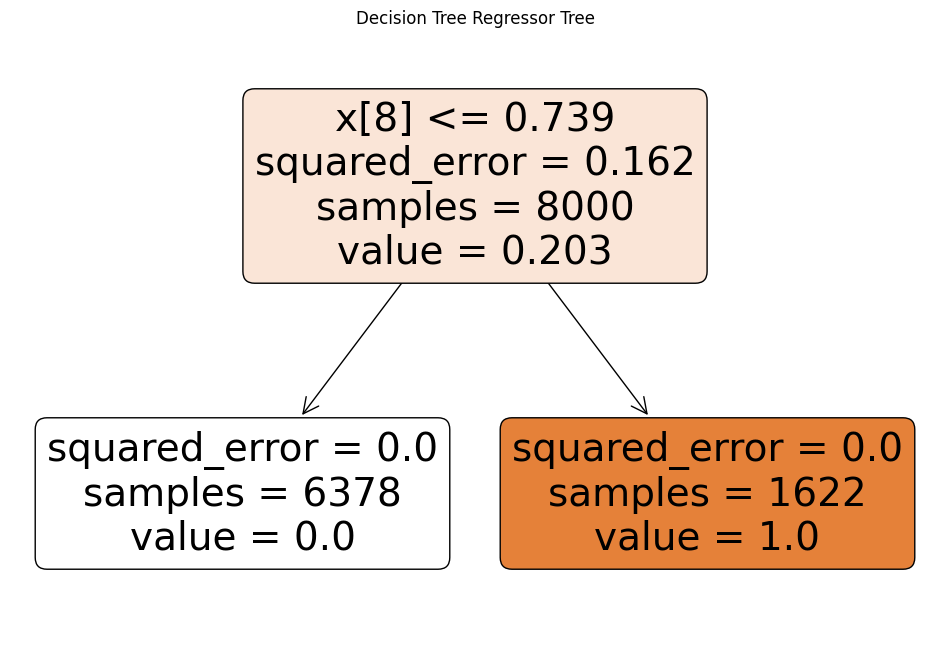

In [21]:
plt.figure(figsize=(12, 8))
plot_tree(model, filled=True, rounded=True)
plt.title('Decision Tree Regressor Tree')
plt.show()